irstly change runtime type to v2-8 TPU, because the volume of seismic 3D

In [ ]:
# Get access to data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
!pip install segyio
!pip install "dask[complete]"
import segyio     #reading, writing, and manipulating seismic data in the SEG-Y format.
import numpy as np
import pandas as pd
import dask.array as da    #for array processing
import dask.dataframe as ddf      #for pandas-like dataframes
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable   #for custom layout
from typing import Dict, List, Tuple, Callable
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
print ("Libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


Libraries imported successfully!


In [ ]:
seismic_data_path = '/content/drive/My Drive/Colab Notebooks/ML FOR Geoscience/Vshale/F3_Seismic_reservoir.sgy'  # Store the file path
seismic_data = segyio.tools.cube(seismic_data_path)  # Load data using the path


In [ ]:
# Inspect Seismic Data
with segyio.open(seismic_data_path, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000   #show sample rate in ms
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 80601, N Samples: 151, Sample rate: 4.0ms, Trace length: 1100.0'

In [ ]:
f = segyio.open(seismic_data_path, xline=segyio.tracefield.TraceField.CDP)   #open SEGY file as CDP trace header
il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]     #calculate time interval between samples

d = segyio.cube(f)    #load seismic cube
nil, nxl, nt = d.shape
itmin,itmax = int(t[0]), int(t[-1])

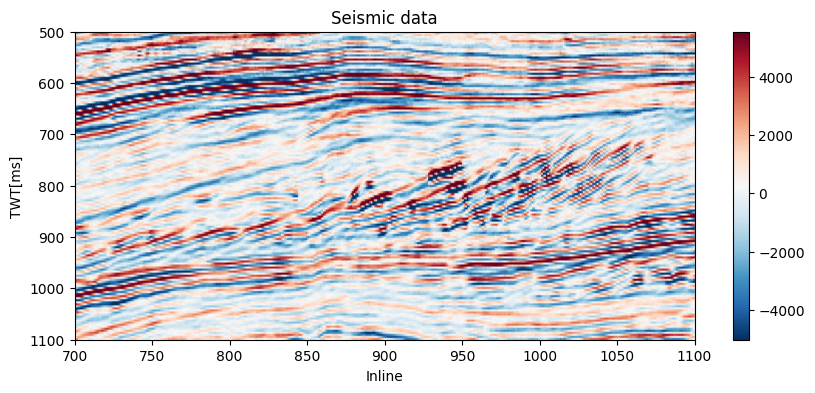

In [ ]:
# Plot seismic section
plt.figure(figsize=(10, 4))
plt.imshow(d[100,:,:].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Inline')
plt.ylabel('TWT[ms]')
plt.show()

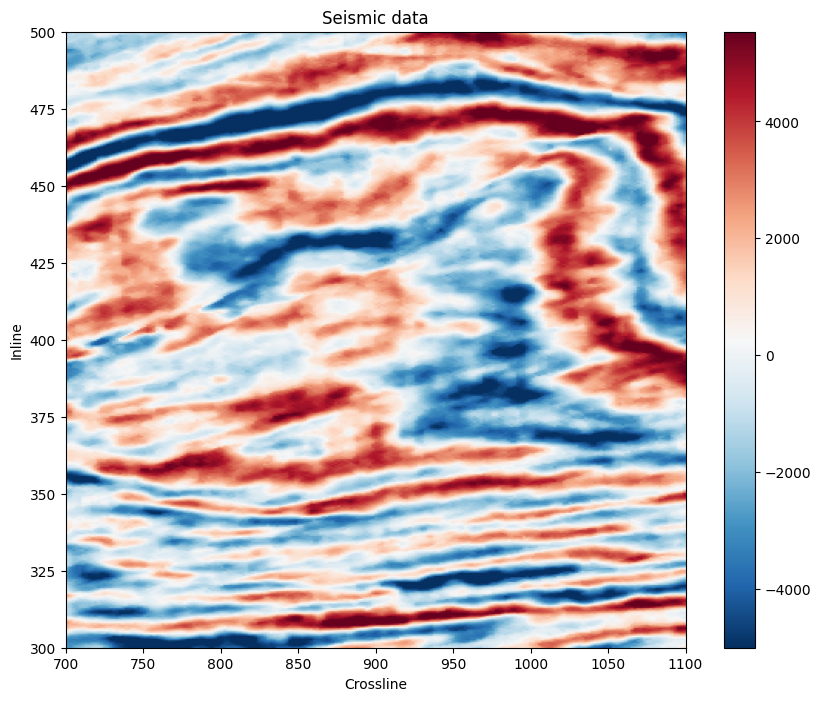

In [ ]:
# Plot time slice
plt.figure(figsize=(10, 8))
plt.imshow(d[:,:,120].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], il[0], il[-1]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Crossline')
plt.ylabel('Inline')
plt.show()

In [ ]:
# Load seismic attributes
# Semblance
seismic_semblance_path = '/content/drive/My Drive/Colab Notebooks/ML FOR Geoscience/Vshale/sem__cross.sgy'  # Store the file path
sem_crosse = segyio.tools.cube(seismic_semblance_path)  # Load data using the path
# Energy
seismic_Energy_path = '/content/drive/My Drive/Colab Notebooks/ML FOR Geoscience/Vshale/Energy.sgy'  # Store the file path
Energy = segyio.tools.cube(seismic_Energy_path)  # Load data using the path
# Amlitude
seismic_Amplitude_path = '/content/drive/My Drive/Colab Notebooks/ML FOR Geoscience/Vshale/Amp_1.sgy'  # Store the file path
Amp_1 = segyio.tools.cube(seismic_Amplitude_path)  # Load data using the path
print ("Data loaded successfully!")

Data loaded successfully!


In [ ]:
# Flatten the seismic attributes 3D cubes
Energy_f= Energy.flatten()
sem_crosse_f= sem_crosse.flatten()
Amp_1_f= Amp_1.flatten()


# Create list to make a dataframe of the Seismic 3D cubes
names = ['Energy', 'sem_cross', 'Amp_1']
seismic_df = [Energy_f, sem_crosse_f, Amp_1_f]


# Create daskdataframe of the Seismic 3D cubes
seismic_df = da.stack(seismic_df, axis=1)
seismic_df = ddf.from_dask_array(seismic_df, columns=names).compute()

# check results
seismic_df

,Energy,sem_cross,Amp_1
0,3242441.0,0.744287,5101.835938
1,3301170.0,0.744402,76301.437500
2,3291144.0,0.743161,85871.125000
3,2552251.0,0.740728,31028.683594
4,2497124.0,0.740509,-128943.437500
...,...,...,...
12170746,3203038.0,0.495074,28479.917969
12170747,3142903.0,0.494515,8565.152344
12170748,2648209.0,0.493874,-12822.812500
12170749,3641713.0,0.495705,-58485.121094


In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the data and transform it
seismic_df_sc = scaler.fit_transform(seismic_df)

# Convert the result back to a DataFrame
seismic_df_std = pd.DataFrame(seismic_df_sc, columns=seismic_df.columns)

# check results
seismic_df_std

,Energy,sem_cross,Amp_1
0,-0.493709,-4.024687,0.032834
1,-0.481951,-4.022518,0.368659
2,-0.483958,-4.045927,0.413797
3,-0.631888,-4.091818,0.155122
4,-0.642924,-4.095953,-0.599415
...,...,...,...
12170746,-0.501597,-8.724787,0.143101
12170747,-0.513637,-8.735326,0.049169
12170748,-0.612677,-8.747418,-0.051711
12170749,-0.413772,-8.712884,-0.267086


In [ ]:
# load the Models
import joblib
LR = joblib.load('/content/drive/MyDrive/Colab Notebooks/ML FOR Geoscience/Vshale/linear_regression_model_edit.pkl')
RFR = joblib.load('/content/drive/MyDrive/Colab Notebooks/ML FOR Geoscience/Vshale/random_forest_model_edit.pkl')
NN = joblib.load('/content/drive/MyDrive/Colab Notebooks/ML FOR Geoscience/Vshale/neural_network_model_edit.pkl')
print("Models loaded successfully!")

Models loaded successfully!


In [ ]:
# apply the model to the seismic data
# 1. Linear Regression Model
%time
# Now predict using the model
Predicted_Vsh_LR = LR.predict(seismic_df_std)
print("LR Model applied successfully!")

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.2 µs
LR Model applied successfully!


In [ ]:
# apply the model to the seismic data
# 2. Random Forest Model
%time
Predicted_Vsh_RFR = RFR.predict(seismic_df_std)
print("RFR Model applied successfully!")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
RFR Model applied successfully!


In [ ]:
# apply the model to the seismic data
# 3. Neural Network Model
%time
Predicted_Vsh_NN = NN.predict(seismic_df_std)
print("MLP Model applied successfully!")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 13.4 µs
MLP Model applied successfully!


In [ ]:
# Reshape resultant volumes
Vshale_LR = Predicted_Vsh_LR.reshape(seismic_data.shape)
Vshale_RFR = Predicted_Vsh_RFR.reshape(seismic_data.shape)
Vshale_NN = Predicted_Vsh_NN.reshape(seismic_data.shape)
print("Reshaped successfully!")

Reshaped successfully!


In [ ]:
#@title Export the Porosity
!git clone https://github.com/otavioon/d2geo.git
import h5py
from d2geo.attributes.io import segy_read, segy_write
from shutil import copyfile as cf
output = segy_write(Vshale_LR, seismic_data_path, '/content/drive/MyDrive/Colab Notebooks/ML FOR Geoscience/Vshale/Vshale_LR_edit.segy')
print('Done Exporting')

Cloning into 'd2geo'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 68 (delta 28), reused 28 (delta 28), pack-reused 36 (from 1)
Receiving objects: 100% (68/68), 50.64 KiB | 2.11 MiB/s, done.
Resolving deltas: 100% (37/37), done.


/usr/local/lib/python3.11/dist-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


Done Exporting


In [ ]:
output = segy_write(Vshale_NN, seismic_data_path, '/content/drive/MyDrive/Colab Notebooks/ML FOR Geoscience/Vshale/Vshale_NN_edit.segy')
output = segy_write(Vshale_RFR, seismic_data_path, '/content/drive/MyDrive/Colab Notebooks/ML FOR Geoscience/Vshale/Vshale_RFR_edit.segy')
print('Done Exporting')

Done Exporting


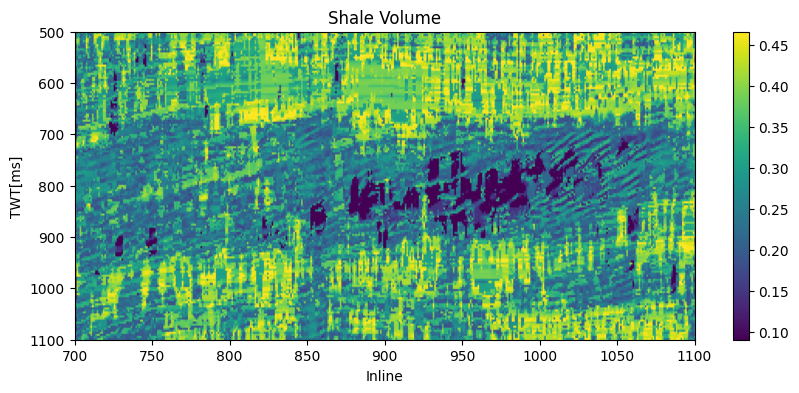

In [ ]:
# Check the Vshale Section by plotting
plt.figure(figsize=(10, 4))
plt.imshow(Vshale_LR[100,:,:].T, cmap='viridis',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(Vshale_LR, 2),
           vmax=np.percentile(Vshale_LR, 98))
plt.title('Shale Volume')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Inline')
plt.ylabel('TWT[ms]')
plt.show()

download the volume output from drive to desk to upload to opendect and check.
in this case we find the best result is RFR prediction